In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 6
fig_height = 4
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Process"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


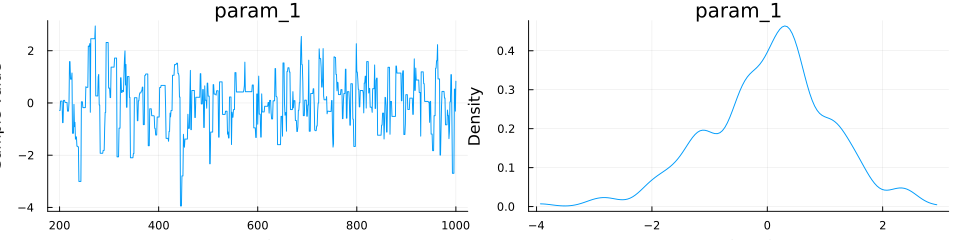

In [2]:
# Taken from https://mvihola.github.io/docs/AdaptiveMCMC.jl/

# Load the package
using AdaptiveMCMC

# Define a function which returns log-density values:
log_p(x) = -.5*sum(x.^2)

# Run 10k iterations of the Adaptive Metropolis:
out = adaptive_rwm(zeros(2), log_p, 1_000; algorithm=:am)

using MCMCChains, StatsPlots # Assuming MCMCChains & StatsPlots are installed...
c = Chains(out.X[1,:], start=out.params.b, thin=out.params.thin); plot(c)

Accept ratio Metropolis: 0.41194


Accept ratio emcee: 0.41194


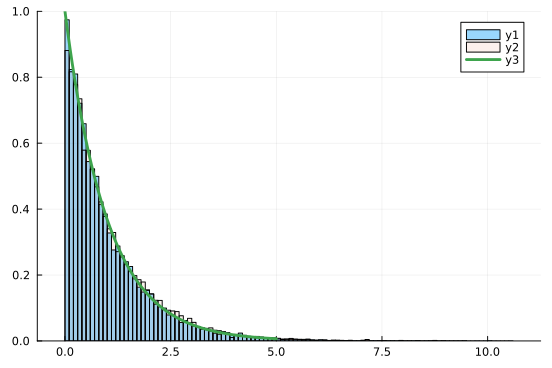

In [3]:
using KissMCMC
# the distribution to sample from,
logpdf(x::T) where {T} = x<0 ? -convert(T,Inf) : -x  # <1>
# initial point of walker
theta0 = 0.5

# Metropolis MCMC sampler:
sample_prop_normal(theta) = 1.5*randn() + theta # samples the proposal (or jump) distribution
thetas, accept_ratio = metropolis(logpdf, sample_prop_normal, theta0, niter=10^5)
println("Accept ratio Metropolis: $accept_ratio")

# emcee MCMC sampler:
thetase, accept_ratioe = emcee(logpdf, make_theta0s(theta0, 0.1, logpdf, 100), niter=10^5)
# check convergence using integrated autocorrelation
thetase, accept_ratioe = squash_walkers(thetase, accept_ratioe) # puts all walkers into one
println("Accept ratio emcee: $accept_ratio")

using Plots
histogram(thetas, normalize=true, fillalpha=0.4)
histogram!(thetase, normalize=true, fillalpha=0.1)
plot!(0:0.01:5, map(x->exp(logpdf(x)[1]), 0:0.01:5), lw=3)